<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#First-step:-estimates-the-necessary-quadrupole-variation-to-perform-emittance-crossing" data-toc-modified-id="First-step:-estimates-the-necessary-quadrupole-variation-to-perform-emittance-crossing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>First step: estimates the necessary quadrupole variation to perform emittance crossing</a></span></li><li><span><a href="#Building-auxiliary-functions" data-toc-modified-id="Building-auxiliary-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Building auxiliary functions</a></span></li><li><span><a href="#Emittance-exchange-simulation-(open-code)" data-toc-modified-id="Emittance-exchange-simulation-(open-code)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Emittance exchange simulation (open code)</a></span></li><li><span><a href="#Energy/emittance-oscillations-analysis" data-toc-modified-id="Energy/emittance-oscillations-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Energy/emittance oscillations analysis</a></span><ul class="toc-item"><li><span><a href="#Emittance-oscillations-with-constant-KL,-Delta-e-N" data-toc-modified-id="Emittance-oscillations-with-constant-KL,-Delta-e-N-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Emittance oscillations with constant KL, Delta e N</a></span></li><li><span><a href="#C-constant,-varying-$\Delta$" data-toc-modified-id="C-constant,-varying-$\Delta$-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>C constant, varying $\Delta$</a></span></li></ul></li><li><span><a href="#Making-the-heat-map-of-emittance-exchange-quality(No-damping-and-QE)" data-toc-modified-id="Making-the-heat-map-of-emittance-exchange-quality(No-damping-and-QE)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Making the heat map of emittance exchange quality(No damping and QE)</a></span></li><li><span><a href="#S-and-t-values" data-toc-modified-id="S-and-t-values-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>S and t values</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from apsuite.emittance_exchange.bo_tune_measure import tune_measure as tm
import pymodels as pm
import pyaccel as pa
%config Completer.use_jedi = False
import pandas as pd
import seaborn as sns
from numpy.fft import rfft, rfftfreq, irfft
from scipy.signal import hilbert
from IPython.display import display, Math, Markdown
T_r = 1.657 * 1e-3 #  Revolution period [ms]
KL_crossing = 0.18911

# First step: estimates the necessary quadrupole variation to perform emittance crossing

Our objective is find the quadrupoles strength that makes $\Delta = \hat{\nu}_x - \hat{\nu}_y = 0$, in the machine without coupling. When we set some coupling, this configuration leads to emmitance crossing. 

The relation between the a variation in quadrupoles and a variation in tunes are:

\begin{equation}
d K \approx \pm \frac{4 \pi \, d \nu}{\sum \beta_i l_i}
\end{equation}

where $\beta_i$ and $l_i$ refers to the average $\beta$-function over and
the length of quadrupole i, respectively. The sign depends
on the plane (positive for the horizontal plane and negative
for the vertical plane), and, similarly, the $\beta$ i is either the
horizontal or vertical $\beta$-function.

*Notation remark*: In this notebook i am using $d f$ notation as a reference to a finite variation of f, like the usual $\Delta f$, that was discarded because the $\Delta$ is already used to represent tune difference. Do not think $d f$ as infinitesimal variation.

* Creating the machine

In [16]:
obj = tm.BPMeasure()
obj.create_booster(rad=False, QF_KL=None, KsL=None)
tune1, tune2 = obj._eqparams.tune1, obj._eqparams.tune2
delta = tune1%1 - tune2%1
initial_delta = delta

display(Math(r"\nu_x = {:.2f}, \\ \nu_y = {:.2f},\\ \Delta = {:.2f}.".format(tune1, tune2, delta)))

<IPython.core.display.Math object>

Lets suppose that the emittance exchange will be occur in a **static case**, where from cycle to cycle the tune in one plane is usually varied, keeping the other fixed. Both tunes remain constant during each cycle.

So, lets consider that $d \nu_y \approx 0$ when varying $\nu_x$ in order to get $\Delta = 0$.

Consider that $\Delta_0 + d\Delta =0$, where $\Delta_0$ is the initial tune separation and $d \Delta$ is the variation of $\Delta$ during the emittance exchange process. Therefore:

\begin{equation}
d \hat{Q}_x =  - \Delta_0
\end{equation}

Therefore, the needed variation in quadrupoles is
\begin{equation}
d K_x = - \frac{4 \pi \Delta_0}{\sum \beta_i l_i}
\end{equation}

But, for some reason that I couldn't explain, the above formula only returns the right values if we divide the right side by 2.

\begin{equation}
d K_x = - \frac{2 \pi \Delta_0}{\sum \beta_i l_i} 
\end{equation}

In [3]:
qf_idx = obj._famdata['QF']['index'].copy()
spos = obj._et.spos
betax = obj._et.beta1
betay = obj._et.beta2

In [4]:
# Assuming that the QF quadrupoles have equally lengths:
l = obj._bo[qf_idx[0]].length 
betasx = np.zeros(len(qf_idx))
betasy = betasx.copy()

for i,idx in enumerate(qf_idx):
    idx1, idx2 = idx
    betay_values = betay[[idx1, idx2, idx2+1]]
    betax_values = betax[[idx1, idx2, idx2+1]]
    betasx[i] = np.mean(betax_values)
    betasy[i] = np.mean(betay_values)
sum_beta_l =  2*l*(np.sum(betasx) + np.sum(betasy))

In [5]:
deltaK = -4*np.pi*delta/(sum_beta_l)
deltaKL = deltaK * l
print("d K = {} m^-2 \n d KL = {} m^-1 ".format(deltaK, deltaKL))

d K = 0.002117107330882981 m^-2 
 d KL = 0.0004827004714413197 m^-1 


* Lets test this value with a new machine and check the tune values.

In [6]:
obj2 = tm.BPMeasure()
obj2.create_booster()
KL_default = obj2._bo[qf_idx[0][0]].KL

KL_crossing = KL_default + deltaKL # The last term is an euristic correction
K_crossing = KL_crossing/l
obj2.create_booster(rad=False, QF_KL=KL_crossing)
tunex, tuney = obj2._eqparams.tune1, obj2._eqparams.tune2

display(Math(r" K_(QF) = {:.5f} \\ KL_(QF) = {:.5f} \\ \nu_x = {:.5f} \\ \nu_y = {:.5f}".format(K_crossing, KL_crossing, tunex%1 , tuney%1)))

<IPython.core.display.Math object>

# Building auxiliary functions


Defining the function witch computes emittance exchange quality 

In [7]:
def calc_R(emit1_0, emit2_0, emit1):
    R = 1 - (emit1 - emit2_0)/(emit1_0 - emit2_0)
    return R

In [8]:
def C_to_KsL(acc, C):
    fam_data = pm.bo.get_family_data(acc)
    qs_idx = fam_data['QS']['index']
    ed_tang, *_ = pa.optics.calc_edwards_teng(accelerator=acc)
    beta1 = ed_tang.beta1[qs_idx[0]]
    beta2 = ed_tang.beta2[qs_idx[0]]
    KsL = -2 * np.pi * C / np.sqrt(beta1 * beta2)
    
    return KsL[0]

In [9]:
def KsL_to_C(acc, KsL):
    fam_data = pm.bo.get_family_data(acc)
    qs_idx = fam_data['QS']['index']
    ed_tang, *_ = pa.optics.calc_edwards_teng(accelerator=acc)
    beta1 = ed_tang.beta1[qs_idx[0][0]]
    beta2 = ed_tang.beta2[qs_idx[0][0]]
    C = np.abs(KsL * np.sqrt(beta1 * beta2)/(2 * np.pi))
    return C

Creating a function to compute $\sum \beta_i l_i$

(Only valid for booster - single skew quadrupole)

In [10]:
def compute_sum_beta_l(acc):    
    ed_teng, _ = pa.optics.calc_edwards_teng(bo)
    famdata = pm.bo.get_family_data(acc)
    qf_idx = famdata['QF']['index'].copy()
    
    betax = ed_teng.beta1
    betay = ed_teng.beta2
    l = bo[qf_idx[0]].length 
    betasx = np.zeros(len(qf_idx))
    betasy = betasx.copy()

    for i, idx in enumerate(qf_idx):
        idx1, idx2 = idx
        betay_values = betay[[idx1, idx2, idx2+1]]
        betax_values = betax[[idx1, idx2, idx2+1]]
        betasx[i] = np.mean(betax_values)
        betasy[i] = np.mean(betay_values)
    sum_beta_l =  2*l*(np.sum(betasx) + np.sum(betasy))

    return sum_beta_l, l

Creating a function to help us to initialize the machine with $\Delta = - A|C|$, with A being a real number. 

In [11]:
def set_tune_sep(acc, delta_f):
    "Sets delta to delta_f"
       
    bo = acc[:]
    famdata = pm.bo.get_family_data(bo)
    qf_idx = np.array(famdata['QF']['index']).flatten()
    qs_idx = famdata['QS']['index']
    eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
#     ed_teng, _ = pa.optics.calc_edwards_teng(bo)
    KsL = acc[qs_idx[0][0]].KsL
    C = KsL_to_C(acc, KsL)
    
    tune1, tune2 = eqparams.tune1, eqparams.tune2
    delta_c = tune1 - tune2
    delta = np.sign(delta_c) * np.sqrt(delta_c**2 - C**2)
    
    sum_beta_l, l = compute_sum_beta_l(bo)
    dv_x = delta_f - delta
    deltaK_x = 4*np.pi*dv_x/(sum_beta_l)
    deltaKL_x = deltaK_x * l
    
    KL_x  = bo[qf_idx[0]].KL
    for qf in qf_idx:
        bo[qf].KL = KL_x + deltaKL_x
    
    eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
    tune1, tune2 = eqparams.tune1, eqparams.tune2
    delta_c = tune1 - tune2
    delta = np.sign(delta_c) * np.sqrt(delta_c**2 - C**2)
    
    #display(Math(r"\nu_1 = {:.3f} \\ \nu_2 = {:.3f}".format(tune1%1 , tune2%1)))
    #print(rf"$\Delta$ setted to {delta}")
    return bo, delta

Searching for values of coupling that avoid integer resonances 

In [ ]:
KsL_list = np.linspace(0.001, 0.03, num=10)
deltas = np.zeros(KsL_list.size)
tune1 = np.zeros(KsL_list.size)
tune2 = tune1.copy()
A = 6
C_list = deltas.copy()
precision = C_list.copy()
for i, ksl in enumerate(KsL_list):
    objtest2 = tm.BPMeasure()
    objtest2.create_booster(KsL = ksl)
    C = objtest2._coupling_coef
    C_list[i] = C
    objtest2, deltas[i] = set_tune_sep(objtest2, -A*C)
    tune1[i] = objtest2.eqparams.tune1
    tune2[i] = objtest2.eqparams.tune2
    deltas[i] /= C

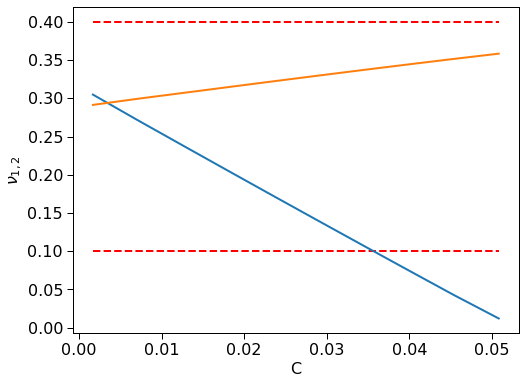

In [68]:
plt.plot(C_list, tune1)
plt.plot(C_list, tune2)
plt.hlines(0.1, np.min(C_list), np.max(C_list), 'r', linestyle='--')
plt.hlines(0.4,  np.min(C_list), np.max(C_list), 'r', linestyle='--')
plt.xlabel('C')
plt.ylabel(r'$\nu_{1,2}$')
plt.show()

Lets limit our coupling coefficient to $ 0.01 < C < 0.03 $

In [ ]:
C_min = 0.01
C_max = 0.03
KsL_min = C_to_KsL(objtest2._bo, C_min)
KsL_max = C_to_KsL(objtest2._bo, C_max)
print(' KsL minimum: {:.4f} \n KsL maximum: {:.4f}'.format(KsL_min, KsL_max))

# Emittance exchange simulation (open code)

Creating the machine


In [12]:
bo = pm.bo.create_accelerator(energy=3e9)
bo.vchamber_on = True
bo.cavity_on = True
bo.radiation_on = False

# Geting information 
famdata = pm.bo.get_family_data(bo)

# Setting coupling
KsL = -0.01
qs_idx = famdata['QS']['index']
bo[qs_idx[0][0]].KsL = KsL

#Getting default quadrupoles strength
qf_idx = famdata['QF']['index']
KL_default = bo[qf_idx[0][0]].KL
#KL_crossing = 0.18911

ed_teng, _ = pa.optics.calc_edwards_teng(bo)
C, _ = pa.optics.estimate_coupling_parameters(ed_teng)
print(f'Coupling coefficient: {C}')

Coupling coefficient: 0.016877104737160767


Creating the bunch

In [13]:
# Creating the bunch
eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
emit1, emit2 = eqparams.emit1, np.abs(eqparams.emit2)
sigmae, sigmal = eqparams.espread0, eqparams.bunlen
# #redistributing emittances
# emit = emit1 + emit2
# emit1, emit2 =  0.8*emit, 0.2*emit

bunch = pa.tracking.generate_bunch(n_part=1000, emit1=emit1,
                                                  emit2=emit2,
                                                  optics=ed_teng[0],
                                                  sigmae=sigmae, sigmas=sigmal)
co = pa.tracking.find_orbit6(accelerator=bo, indices=[0])
bunch += co - np.mean(bunch, axis=1)[:, None]

Tracking the emittance exchange

In [161]:
bo2 = bo[:]
bo2, delta = set_tune_sep(bo2, -6*C)
S = 10
# N = 100 # Turns until the exchange
N = int(np.abs(delta)/(S * C**2))

print("Initial delta = {:.3f} [C]".format(delta/C))
qf_idx = np.array(famdata['QF']['index']).flatten()

KL_default = bo2[qf_idx[0]].KL

dKL = KL_crossing - KL_default
KL_list = np.linspace(KL_default, KL_default + 2*dKL, 2*N)

# emitx_list = np.zeros(KL_list.shape)
# emity_list = emitx_list.copy()
emit1_list = np.zeros(2*N)
emit2_list = emit1_list.copy()

tune1_list, tune2_list = emit1_list.copy(), emit1_list.copy()

bunch0 = bunch

# The first N steps are to perfom emittance crossing and the last 
# N are to complete the exchange.
for i, KL in enumerate(KL_list):
    
    # Changing quadrupole forces
    for qf in qf_idx:
        bo2[qf].KL = KL
    
    # Making the linear map
    
    m66 = pa.tracking.find_m66(bo2)
    bunch0 = np.dot(m66, bunch0)
    
    # Computing the RMS emittance
    twi, *_ = pa.optics.calc_twiss(bo2)
    etax, etapx = twi.etax[0], twi.etapx[0]
    etay, etapy = twi.etay[0], twi.etapy[0]
    disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])
    bunch_nodisp = bunch0 - bunch0[4]*disp - np.mean(bunch0, axis=1)[:, None]
    
    ed_teng, *_ = pa.optics.calc_edwards_teng(bo2)
    R = ed_teng.R[0]
    sigmas = np.linalg.inv(R) @ np.cov(bunch_nodisp)[0:4, 0:4] @ np.linalg.inv(R.T)
    
    emit1_list[i] = np.sqrt(np.linalg.det(sigmas[:2,:2]))
    emit2_list[i] = np.sqrt(np.linalg.det(sigmas[2:4,2:4]))

    # Computing Tunes
    eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
    tune1_list[i], tune2_list[i] = eqparams.tune1, eqparams.tune2
    
    # Printing progress
    if i % 100 == 0:
        print(f"step {i}/{2*N}", end='\t')
    if i % 500 == 0:
        print('')

Initial delta = -5.858 [C]
step 0/64	


Plotting the results

In [162]:
plt.style.use(['notebook', 'no-latex'])
deltae = tune1_list - tune2_list
C = np.min(np.abs(deltae)) # True coupling coefficent
delta = np.sign(deltae)*np.sqrt(deltae**2 - C**2)
R = calc_R(emit1_list[0], emit2_list[0], emit1_list)

fig,ax = plt.subplots(3,1, sharex=False)

Ns = np.arange(len(delta))
t = Ns * T_r

ax[0].plot(delta/C, emit1_list*1e9)
ax[0].plot(delta/C, emit2_list*1e9)
ax[0].set_ylabel(r"$\epsilon_{1,2}$ [nm]")
ax[0].set_xlabel(r'$\Delta [C]$')
ax[0].set_title('C={:.2f}, S={:.2f}, radiation off'.format(C, S))

ax[1].plot(t, tune1_list)
ax[1].plot(t, tune2_list)
ax[1].set_ylabel(r"$\nu_{x,y}$")

ax[2].plot(t, R)
ax[2].set_ylabel('$R$')
ax[2].set_xlabel("Time [ms]")
ax[2].hlines(1, np.min(t), np.max(t), linestyle='--')

plt.tight_layout()
plt.show()

# Energy/emittance oscillations analysis

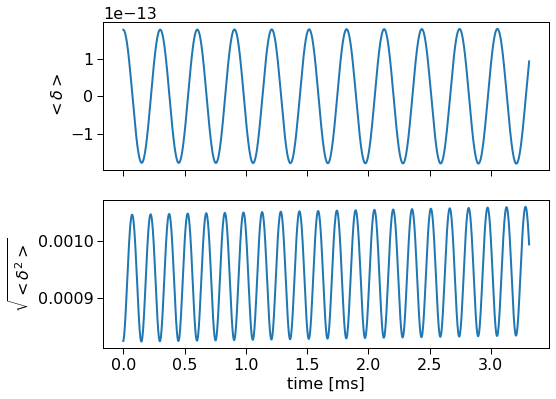

In [49]:
#plt.plot(ed_teng.spos, ed_teng.beta1)
fig,ax = plt.subplots(2,1, sharex=True)

ax[0].plot(t, energy_info[0])
ax[0].set_ylabel("$< \delta >$")
ax[1].plot(t, np.sqrt(energy_info[1]))
ax[1].set_ylabel(r"$\sqrt{<\delta^2>}$")

ax[1].set_xlabel("time [ms]")
plt.show()

Filtering the data

In [235]:
fftx = np.abs(rfft(emitx_list ))
ffty = np.abs(rfft(emity_list ))
fftx /= (fftx.max() - fftx.min())
mean_energy_spec = np.abs(rfft(energy_info[0] ))
mean_energy_spec /= mean_energy_spec.max() - mean_energy_spec.min()
std_energy_spec = np.abs(rfft(energy_info[1] ))
std_energy_spec /= std_energy_spec.max() - std_energy_spec.min()
freqs = rfftfreq(window.size, t[-1]/(2*N))

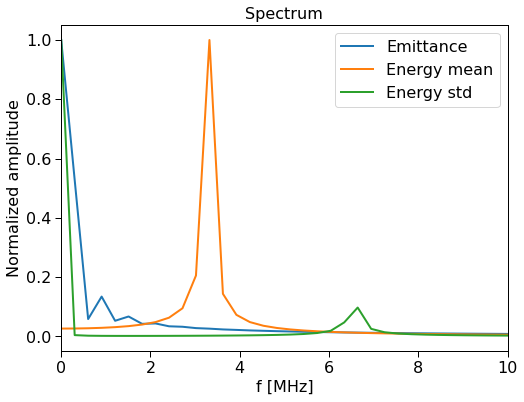

In [236]:
start = 0
plt.plot(freqs[start:], fftx[start:], label="Emittance")
plt.plot(freqs[start:], mean_energy_spec[start:], label="Energy mean" )
plt.plot(freqs[start:], std_energy_spec[start:], label="Energy std" )

#plt.plot(freqs[15:], ffty[15:])
plt.title("Spectrum")
plt.xlabel('f [MHz]')
plt.ylabel("Normalized amplitude")
plt.legend()
plt.xlim([0,10])
plt.show()

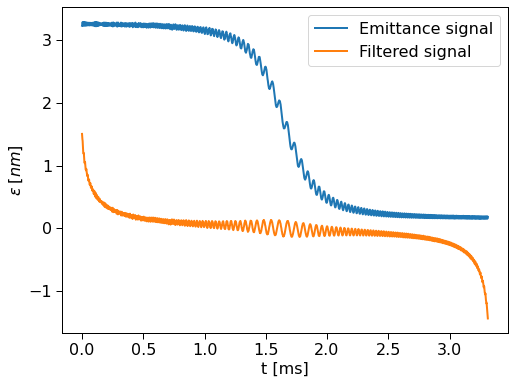

In [223]:
fftx = rfft(emitx_list)[6:]
ifftx = irfft(fftx, n = 2*N)
t2=t
plt.plot(t, emitx_list*1e9, label='Emittance signal')
plt.plot(t2, ifftx*1e9, label='Filtered signal' )
plt.ylabel("$\epsilon \; [nm]$")
plt.xlabel('t [ms]')
plt.legend()

Finding the instantaneous frequency

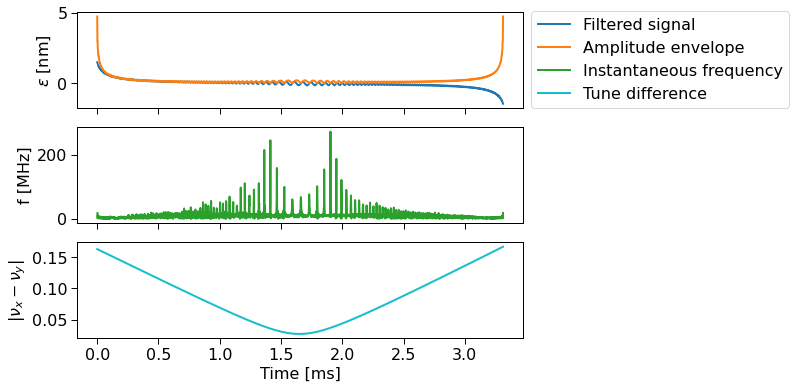

In [233]:
fs = 1/T_r
analytic_signal = hilbert(ifftx)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi) * fs)
amplitude_envelope = np.abs(analytic_signal)
fig, ax = plt.subplots(3,1, sharex=True)
ax[0].plot(t2, ifftx*1e9, label="Filtered signal")
ax[0].plot(t2, amplitude_envelope*1e9,  label="Amplitude envelope")
ax[0].set_ylabel("$\epsilon$ [nm]")
ax[1].plot(t2[1:], np.abs(instantaneous_frequency),c='tab:green', label="Instantaneous frequency")
ax[1].set_ylabel('f [MHz]')

ax[2].plot(t, abs(deltae),  c = 'tab:cyan', label='Tune difference')
ax[2].set_xlabel('Time [ms]')
ax[2].set_ylabel(r"$|\nu_x - \nu_y|$")
fig.legend(bbox_to_anchor=(0.9,0.9),loc="upper left")
plt.tight_layout
plt.show()

## Emittance oscillations with constant KL, Delta e N

In [81]:
# Setting coupling
KsL_list = [-0.005, -0.01, -0.02]
C_list = [KsL_to_C(bo, x) for x in KsL_list]
N = 300 # Turns until the exchange

emitx_list = np.zeros([len(KsL_list), 2*N]) # (Coupling, Turn )
emity_list = emitx_list.copy()
tune1_list, tune2_list = emitx_list.copy(), emitx_list.copy()
# energy_info = np.zeros([2, KL_list.size])

for n, KsL in enumerate(KsL_list):
    
    print(f"KsL = {KsL}, group {n+1} started")
    
    # Setting initial tune separation
    bo, delta = set_tune_sep(bo, -6*C)
    print("Initial delta = {:.3f} [C]".format(delta/C))
    
    qs_idx = famdata['QS']['index']
    bo[qs_idx[0][0]].KsL = KsL
    
    bunch0 = bunch

    # The first N steps are to perfom emittance crossing and the last 
    # N are to complete the exchange.
    for i in range(2*N):
        # Making the linear map
        m66 = pa.tracking.find_m66(bo)
        bunch0 = np.dot(m66, bunch0)

        # Computing the RMS emittance
        twi, *_ = pa.optics.calc_twiss(bo)
        etax, etapx = twi.etax[0], twi.etapx[0]
        etay, etapy = twi.etay[0], twi.etapy[0]
        disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])
        bunch_nodisp = bunch0 - bunch0[4]*disp - np.mean(bunch0, axis=1)[:, None]
        emitx_list[n, i] = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[:2,:])))
        emity_list[n, i] = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4,:])))

        # Computing Tunes
        eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
        tune1_list[n, i], tune2_list[n, i] = eqparams.tune1, eqparams.tune2

        # Saving the beam energy through the exchange
#         energy_info[0,i] = np.mean(bunch0[4])
#         energy_info[1,i] = np.var(bunch0[4])

        # Printing progress
        if i % 100 == 0:
            print(f"step {i}", end='\t')
        if i % 500 == 0:
            print('')

KsL = -0.005, group 1 started
Initial delta = -5.989 [C]
step 0	
step 100	step 200	step 300	step 400	step 500	
KsL = -0.01, group 2 started
Initial delta = -6.000 [C]
step 0	
step 100	

KeyboardInterrupt: 

In [21]:
plt.style.use(['notebook', 'no-latex'])
Ns = np.arange(2*N)
t = Ns * T_r
fig, ax = plt.subplots(3,1, sharex=True, sharey = True)
deltae = tune1_list[0] - tune2_list[0]

for i, C in enumerate(C_list):
    ax[i].plot(t, emitx_list[i,:]*1e9, label="C = {:.2f}".format(C))
    #ax[1].plot(t, emity_list[i,:]*1e9)

#ax[0].set_ylabel(r"$\epsilon_x$ [nm]")
ax[0].set_title('$|\Delta| = 6 C$, radiation off'.format(C, S))
ax[1].set_ylabel(r"$\epsilon_x$ [nm]")
ax[1].set_xlabel(r'time [ms]')

fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
ax[0].set_xlim([0,0.3])
plt.show()

NameError: name 'T_r' is not defined

In [272]:
amps = np.max(emitx_list, axis=1) - np.min(emitx_list, axis=1)
print(amps)

[5.72247227e-11 6.77999799e-11 6.34523357e-11]


## C constant, varying $\Delta$

In [ ]:
# Setting coupling
KsL = -0.01
A_list = [-5, -6, -8]
N = 300 # Turns until the exchange

emitx_list = np.zeros([len(A_list), 2*N]) # (Coupling, Turn )
emity_list = emitx_list.copy()
tune1_list, tune2_list = emitx_list.copy(), emitx_list.copy()
# energy_info = np.zeros([2, KL_list.size])

for n, A in enumerate(A_list):
    
    print(f"$\Delta$ = {A} |C|, group {n+1} started")
    
    # Setting initial tune separation
    bo, delta = set_tune_sep(bo, A*C)
    print("Initial delta = {:.3f} [C]".format(delta/C))
    
    qs_idx = famdata['QS']['index']
    bo[qs_idx[0][0]].KsL = KsL
    
    bunch0 = bunch

    # The first N steps are to perfom emittance crossing and the last 
    # N are to complete the exchange.
    for i in range(2*N):
        # Making the linear map
        m66 = pa.tracking.find_m66(bo)
        bunch0 = np.dot(m66, bunch0)

        # Computing the RMS emittance
        twi, *_ = pa.optics.calc_twiss(bo)
        etax, etapx = twi.etax[0], twi.etapx[0]
        etay, etapy = twi.etay[0], twi.etapy[0]
        disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])
        bunch_nodisp = bunch0 - bunch0[4]*disp - np.mean(bunch0, axis=1)[:, None]
        emitx_list[n, i] = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[:2,:])))
        emity_list[n, i] = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4,:])))

        # Computing Tunes
        eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
        tune1_list[n, i], tune2_list[n, i] = eqparams.tune1, eqparams.tune2

        # Saving the beam energy through the exchange
#         energy_info[0,i] = np.mean(bunch0[4])
#         energy_info[1,i] = np.var(bunch0[4])

        # Printing progress
        if i % 100 == 0:
            print(f"step {i}", end='\t')
        if i % 500 == 0:
            print('')

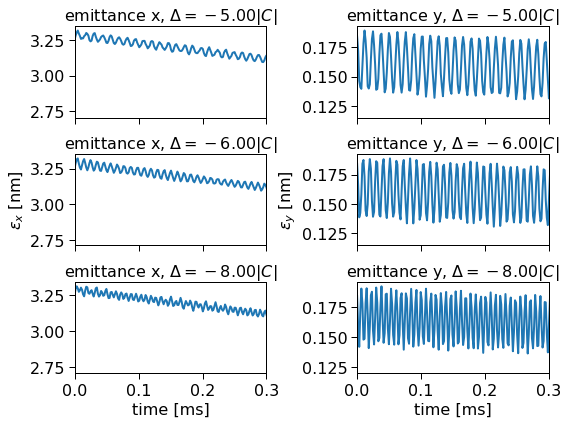

In [42]:
plt.style.use(['notebook', 'no-latex'])
Ns = np.arange(2*N)
t = Ns * T_r
fig, ax = plt.subplots(3,2, sharex=True)
deltae = tune1_list[0] - tune2_list[0]
C = KsL_to_C(bo, KsL)

for i, A in enumerate(A_list):
    ax[i][0].plot(t, emitx_list[i,:]*1e9, label="$\Delta$ = {:.2f} |C|".format(A))
    ax[i][1].plot(t, emity_list[i,:]*1e9)
    ax[i][0].set_title('emittance x, $\Delta={:.2f} |C|$'.format(A))
    ax[i][1].set_title('emittance y, $\Delta={:.2f} |C|$'.format(A))

#ax[0].set_ylabel(r"$\epsilon_x$ [nm]")
ax[1][0].set_ylabel(r"$\epsilon_x$ [nm]")
ax[2][0].set_xlabel(r'time [ms]')
ax[2][1].set_xlabel(r'time [ms]')

ax[1][1].set_ylabel(r"$\epsilon_y$ [nm]")

# fig.legend(loc='upper right')
ax[0][0].set_xlim([0,0.3])
plt.tight_layout()
plt.show()

# Making the heat map of emittance exchange quality(No damping and QE)

\begin{equation}
S = \frac{\dot{\Delta}}{C^2} = \frac{|\Delta_0|}{N \, C^2}
\end{equation}

$\Delta_0$ = Initial uncoupled tunes difference

$N$ = number revolutions until crossing (i.e. $\Delta = 0$)

Choosing $|\Delta_0| = A |C| $, we have

\begin{equation}
S =   \frac{A}{N \, C}
\end{equation}

In [48]:
A = 6
S_list = np.logspace(-1, 2.5, num = 20)
KsL_list = -np.linspace(0.0051, 0.0154, num = 20)
C_list = np.array([KsL_to_C(bo, KsL=KsL) for KsL in KsL_list])
qf_idx = np.array(famdata['QF']['index']).flatten()

R = np.zeros([S_list.size, C_list.size])
R_rad = np.zeros([S_list.size, C_list.size])

In [18]:
for i, S in enumerate(S_list):
    for j, C in enumerate(C_list):
        # Setting unitial machine parameters
        bo2 = bo[:]
        bo2[qs_idx[0][0]].KsL = KsL_list[j]
        bo2, delta = set_tune_sep(bo2, -A*C)

        N = np.abs(delta)/(S * C**2) # Turns until the exchange
        N = int(N)
        if N > 20000:
            R[i, j] = 0
            print(f"N>20000, simulation {i},{j} canceled")
            continue
        else:
            print(f"Simulation {i},{j} started, C={C}, S={S} and N={N}")
        
        KL_default = bo2[qf_idx[0]].KL
        dKL = KL_crossing - KL_default
        KL_list = np.linspace(KL_default, KL_default + 2*dKL, 2*N)

        emitx_list = np.zeros(KL_list.shape)
        emity_list = emitx_list.copy()
        tune1_list, tune2_list = emitx_list.copy(), emitx_list.copy()

        bunch0 = bunch
        
        # The first N steps are to perfom emittance crossing and the last 
        # N are to complete the exchange.
        for n, KL in enumerate(KL_list):
            # Changing quadrupole forces
            for qf in qf_idx:
                bo2[qf].KL = KL

            # Making the linear map
            m66 = pa.tracking.find_m66(bo2)
            bunch0 = np.dot(m66, bunch0)

            # Computing the RMS emittance
            twi, *_ = pa.optics.calc_twiss(bo2)
            etax, etapx = twi.etax[0], twi.etapx[0]
            etay, etapy = twi.etay[0], twi.etapy[0]
            disp = np.array([[etax], [etapx], [etay], [etapy], [0], [0]])
            bunch_nodisp = bunch0 - bunch0[4]*disp - np.mean(bunch0, axis=1)[:, None]
            emitx_list[n] = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[:2,:])))
            emity_list[n] = np.sqrt(np.linalg.det(np.cov(bunch_nodisp[2:4,:])))

            # Computing Tunes
#             eqparams = pa.optics.EqParamsFromBeamEnvelope(bo)
#             tune1_list[i], tune2_list[i] = eqparams.tune1, eqparams.tune2
            
            # Printing progress
            if n % 1000 == 0:
                print(f"step {n}", end='\t')
#             if n % 1000 == 0:
#                 print('')
            if (n==KL_list.size-1):
                print("")
        R[i,j] = calc_R(emitx_list[0], emity_list[0], emitx_list[-1])

Simulation 0,0 started, C=0.00914273361454307, S=0.1 and N=6547
step 0	step 1000	step 2000	step 3000	step 4000	step 5000	step 6000	step 7000	step 8000	step 9000	step 10000	step 11000	step 12000	step 13000	
Simulation 0,1 started, C=0.010114561852208638, S=0.1 and N=5922
step 0	step 1000	step 2000	step 3000	step 4000	step 5000	step 6000	step 7000	step 8000	step 9000	step 10000	step 11000	
Simulation 0,2 started, C=0.011086390089874207, S=0.1 and N=5406
step 0	step 1000	step 2000	step 3000	step 4000	step 5000	step 6000	step 7000	step 8000	step 9000	step 10000	
Simulation 0,3 started, C=0.012058218327539774, S=0.1 and N=4972
step 0	step 1000	step 2000	step 3000	step 4000	step 5000	step 6000	step 7000	step 8000	step 9000	
Simulation 0,4 started, C=0.013030046565205343, S=0.1 and N=4602
step 0	step 1000	step 2000	step 3000	step 4000	step 5000	step 6000	step 7000	step 8000	step 9000	
Simulation 0,5 started, C=0.014001874802870913, S=0.1 and N=4284
step 0	step 1000	step 2000	step 3000	step 40

step 0	
Simulation 7,13 started, C=0.02177650070419546, S=1.9474830399087562 and N=141
step 0	
Simulation 7,14 started, C=0.02274832894186103, S=1.9474830399087562 and N=135
step 0	
Simulation 7,15 started, C=0.0237201571795266, S=1.9474830399087562 and N=129
step 0	
Simulation 7,16 started, C=0.024691985417192166, S=1.9474830399087562 and N=124
step 0	
Simulation 7,17 started, C=0.025663813654857735, S=1.9474830399087562 and N=119
step 0	
Simulation 7,18 started, C=0.026635641892523307, S=1.9474830399087562 and N=115
step 0	
Simulation 7,19 started, C=0.027607470130188872, S=1.9474830399087562 and N=111
step 0	
Simulation 8,0 started, C=0.00914273361454307, S=2.9763514416313175 and N=219
step 0	
Simulation 8,1 started, C=0.010114561852208638, S=2.9763514416313175 and N=198
step 0	
Simulation 8,2 started, C=0.011086390089874207, S=2.9763514416313175 and N=181
step 0	
Simulation 8,3 started, C=0.012058218327539774, S=2.9763514416313175 and N=167
step 0	
Simulation 8,4 started, C=0.01303

step 0	
Simulation 12,8 started, C=0.01691735951586762, S=16.23776739188721 and N=21
step 0	
Simulation 12,9 started, C=0.017889187753533185, S=16.23776739188721 and N=20
step 0	
Simulation 12,10 started, C=0.018861015991198757, S=16.23776739188721 and N=19
step 0	
Simulation 12,11 started, C=0.019832844228864326, S=16.23776739188721 and N=18
step 0	
Simulation 12,12 started, C=0.02080467246652989, S=16.23776739188721 and N=17
step 0	
Simulation 12,13 started, C=0.02177650070419546, S=16.23776739188721 and N=16
step 0	
Simulation 12,14 started, C=0.02274832894186103, S=16.23776739188721 and N=16
step 0	
Simulation 12,15 started, C=0.0237201571795266, S=16.23776739188721 and N=15
step 0	
Simulation 12,16 started, C=0.024691985417192166, S=16.23776739188721 and N=14
step 0	
Simulation 12,17 started, C=0.025663813654857735, S=16.23776739188721 and N=14
step 0	
Simulation 12,18 started, C=0.026635641892523307, S=16.23776739188721 and N=13
step 0	
Simulation 12,19 started, C=0.0276074701301

step 0	
Simulation 17,4 started, C=0.013030046565205343, S=135.38761800225433 and N=3
step 0	
Simulation 17,5 started, C=0.014001874802870913, S=135.38761800225433 and N=3
step 0	
Simulation 17,6 started, C=0.01497370304053648, S=135.38761800225433 and N=2
step 0	
Simulation 17,7 started, C=0.01594553127820205, S=135.38761800225433 and N=2
step 0	
Simulation 17,8 started, C=0.01691735951586762, S=135.38761800225433 and N=2
step 0	
Simulation 17,9 started, C=0.017889187753533185, S=135.38761800225433 and N=2
step 0	
Simulation 17,10 started, C=0.018861015991198757, S=135.38761800225433 and N=2
step 0	
Simulation 17,11 started, C=0.019832844228864326, S=135.38761800225433 and N=2
step 0	
Simulation 17,12 started, C=0.02080467246652989, S=135.38761800225433 and N=2
step 0	
Simulation 17,13 started, C=0.02177650070419546, S=135.38761800225433 and N=2
step 0	
Simulation 17,14 started, C=0.02274832894186103, S=135.38761800225433 and N=1
step 0	
Simulation 17,15 started, C=0.0237201571795266,

IndexError: index 0 is out of bounds for axis 0 with size 0

In [21]:
np.save("R_matrix", R)

In [18]:
R = np.load("R_matrix.npy")

In [14]:
%matplotlib qt5
R = R[:19]
S_mesh, C_mesh  = np.meshgrid(S_list[:19], C_list, indexing='ij')

plt.pcolormesh(S_mesh, C_mesh, R, shading='flat')
plt.colorbar().set_label(label='$R$',size=12,weight='bold')


plt.xscale('log')
plt.xlabel("$S$", fontsize=12)
plt.ylabel("$|C|$", fontsize=12)
# plt.grid()
plt.tight_layout()
plt.show()

NameError: name 'R' is not defined

# S and t values

In [19]:
S = 0.5
# Pna = np.exp(- np.pi**2/S)
C = np.linspace(0.005, 0.05, num=5)
t = 2 * np.abs(initial_delta)/(S*C**2) * T_r
dKL_KL = 0.00048/(0.18911-0.00048)

# Time variation
# cross_vel = 100*dKL_KL/N #[%/turn]
# df = pd.DataFrame(cross_vel, columns=C[0,:], index=S[:, 0])
data = np.concatenate([C[:, None], t[:, None]], axis=1)
data

array([[5.00000000e-03, 2.91507095e+01],
       [1.62500000e-02, 2.75983048e+00],
       [2.75000000e-02, 9.63659817e-01],
       [3.87500000e-02, 4.85339595e-01],
       [5.00000000e-02, 2.91507095e-01]])

In [ ]:
np.savetxt(X=data, fname='data.csv', header='C, t [ms]', delimiter=',', fmt='%3.4f' )